# Fundamental Factor Models

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Fundamentals are data having to do with the asset issuer, like the sector, size, and expenses of the company. We can use this data to build a linear factor model, expressing the returns as

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

There are two different approaches to computing the factors $F_j$, which represent the returns associated with some fundamental characteristics, and the factor sensitivities $b_{ij}$.

##Approach 1: Portfolio Construction

In the first, we start by representing each characteristic of interest by a portfolio: we sort all assets by that characteristic, then build the portfolio by going long the top quantile of assets and short the bottom quantile. The factor corresponding to this characteristic is the return on this portfolio. Then, the $b_{ij}$ are estimated for each asset $i$ by regressing over the historical values of $R_i$ and of the factors.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

We start by getting the fundamentals data for all assets and constructing the portfolios for each characteristic:

In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas as pd

start_date = '2014-07-31'
end_date = '2015-07-31'

# Get market cap and book-to-price for all assets in universe
fundamentals = init_fundamentals()
data = get_fundamentals(query(fundamentals.valuation.market_cap,
                              fundamentals.valuation_ratios.book_value_yield), end_date).T

# Drop missing data
data.dropna(inplace=True)

# Following the Fama-French model, ignore assets with negative book-to-price
data = data.loc[data['book_value_yield'] > 0]

In [2]:
# As per Fama-French, get the top 30% and bottom 30% of stocks by market cap
market_cap_top = data.sort('market_cap')[7*len(data)/10:]
market_cap_bottom = data.sort('market_cap')[:3*len(data)/10]

# Factor 1 is returns on portfolio that is long the top stocks and short the bottom stocks
f1 = (np.mean(get_pricing(market_cap_top.index, fields='price',
                          start_date=start_date, end_date=end_date).pct_change()[1:].T.dropna()) -
      np.mean(get_pricing(market_cap_bottom.index, fields='price',
                          start_date=start_date, end_date=end_date).pct_change()[1:].T.dropna()))

In [3]:
# Repeat above procedure for book-to-price
bp_top = data.sort('book_value_yield')[7*len(data)/10:]
bp_bottom = data.sort('book_value_yield')[:3*len(data)/10]

f2 = (np.mean(get_pricing(bp_top.index, fields='price',
                          start_date=start_date, end_date=end_date).pct_change()[1:].T.dropna()) -
      np.mean(get_pricing(bp_bottom.index, fields='price',
                          start_date=start_date, end_date=end_date).pct_change()[1:].T.dropna()))

Now that we have returns series representing our factors, we can compute the factor model for any return stream using a linear regression. Below, we compute the factor sensitivities for returns on Alcoa stock:

In [4]:
# Get returns data for our asset
asset = get_pricing('AA', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

f3 = bench-treasury_ret

In [5]:
# Perform linear regression to get the coefficients in the model
mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((f1, f2)))).fit()

# Print the coefficients from the linear regression
print'Historical sensitivities of AA returns to factors:\nMarket cap: %f\nB/P: %f' % (mlr.params[1],
                                                                                      mlr.params[2])
# Print the latest values for each of the factors
print '\nValues of factors on 2015-07-31:\nMarket cap: %f\nB/P: %f' % (f1[-1], f2[-1])

Historical sensitivities of AA returns to factors:
Market cap: 0.621094
B/P: 0.501691

Values of factors on 2015-07-31:
Market cap: 0.002490
B/P: -0.008622


In [6]:
df = pd.DataFrame({'R': asset,
              'F1': f1,
              'F2': f2,
              'F3': f3})
df = df.dropna()

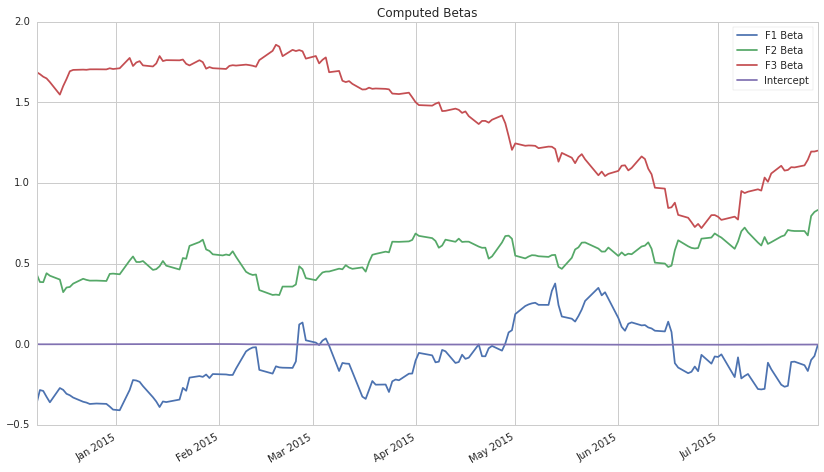

In [7]:
model = pd.stats.ols.MovingOLS(y = df['R'], x=df[['F1', 'F2', 'F3']], 
                             window_type='rolling', 
                             window=90)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();
plt.title('Computed Betas');
plt.legend(['F1 Beta', 'F2 Beta', 'F3 Beta', 'Intercept'])

##Approach 2: Factor Value Normalization

With the other method, we calculate the coefficients $b_{ij}$ from the formula

$$ b_{ij} = \frac{\text{Value of factor for asset }i - \text{Average value of factor}}{\sigma(\text{Factor values})} $$

By scaling the value of the factor in this way, we make the coefficients comparable across factors. The exceptions to this formula are indicator variables, which are set to 1 for true and 0 for false. One example is industry membership: the coefficient tells us whether the asset belongs to the industry or not. After we calculate all of the coefficients, we estimate $F_j$ and $a_i$ using a cross-sectional regression (i.e. at each time step, we perform a regression using the equations for all of the assets).

Following this procedure, we get the cross-sectional returns on 2015-07-31, and compute the coefficients for all assets:

In [8]:
# Get one day's worth of cross-sectional returns
cs_returns = get_pricing(data.index, fields='price',
                         start_date='2015-07-30', end_date='2015-07-31').pct_change()[1:].T.dropna()

# Only look at fundamentals data of assets that we have pricing data for
data = data.loc[cs_returns.index]

# Compute coefficients according to formula above
coeffs = (data - data.mean())/data.std()

Now that we have the factor sensitivities, we use a linear regression to compute the factor betas on 2015-07-31:

In [9]:
mlr = regression.linear_model.OLS(cs_returns,
                                  sm.add_constant(coeffs)).fit()

In [10]:
# Print the coefficients we computed for AA
print 'Sensitivities of AA returns:\n', coeffs.iloc[0]

# Print factor values from linear regression
print '\nFactors on 2015-07-31:\n', mlr.params[1:]

Sensitivities of AA returns:
market_cap          0.168669
book_value_yield    0.175679
Name: Equity(2 [AA]), dtype: float64

Factors on 2015-07-31:
market_cap         -0.000758
book_value_yield   -0.002941
dtype: float64


##Using Fundamental Factor Modeling

###Returns Prediction

As discussed in the Arbitrage Price Theory lecture, factor modeling can be used to predict future returns based on current fundamental factors, or to determine when an asset may be mispriced. Modeling future returns is accomplished by offsetting the returns in the regression, so that rather than predicted for current returns, you are predicting for future returns. Once you have a predictive model, the most canonical way to create a strategy is to attempt a long-short equity approach.

There will be a full lecture describing long-short equity, but the general idea is that you rank equities based on their predicted future returns. You then long the top p% and short the bottom p% remaining neutral on dollar volume. If the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, and assets at the bottom tend to make $5\%$ less, then you will make $(M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ percent per year, where $M$ is the market return that gets canceled out.

###Hedging out Exposure

Once we've determined that we are exposed to a factor, we may want to avoid depending on the performance of that factor by taking out a hedge. This is discussed in the Beta Hedging lecture and also in the Risk Factor Exposure notebook.